**Introduction**

The goal of this analysis is to understand how overall market sentiment (Fear vs Greed) relates to trader behavior and performance.

The Fear and Greed Index reflects the general mood of the crypto market on each day, while the Hyperliquid trader dataset captures actual trading activity. By combining these two sources at a daily level, we can explore whether traders behave differently during fearful versus greedy market conditions.

In [52]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)


In [53]:
from google.colab import files
uploaded = files.upload()


Saving fear_greed_index.csv to fear_greed_index (1).csv


In [54]:
from google.colab import files
uploaded = files.upload()


Saving historical_data.csv to historical_data (1).csv


In [55]:
import os
print(os.listdir())


['.config', 'fear_greed_index.csv', 'historical_data.csv', 'historical_data (1).csv', 'fear_greed_index (1).csv', 'sample_data']


In [56]:
# Load datasets
sentiment_df = pd.read_csv('fear_greed_index.csv')
trader_df = pd.read_csv('historical_data.csv')

# Quick check
print("Sentiment data shape:", sentiment_df.shape)
print("Trader data shape:", trader_df.shape)


Sentiment data shape: (2644, 4)
Trader data shape: (211224, 16)


In [57]:
# Preview
print("Sentiment Data Preview:")
display(sentiment_df.head())

print("\nTrader Data Preview:")
display(trader_df.head())


Sentiment Data Preview:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05



Trader Data Preview:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [58]:
print("Sentiment Data Info:")
sentiment_df.info()

print("\nTrader Data Info:")
trader_df.info()


Sentiment Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB

Trader Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  obje

**Data Preparation**

Both datasets were first inspected for structure, data types, and missing values.

The trader dataset contained timestamp formatting inconsistencies, so timestamps were parsed carefully and rows with unresolvable timestamps were removed to ensure reliable daily aggregation.

Trader activity was then aggregated at a daily level (total trades, volume, average PnL, win rate, etc.) and merged with the daily Fear and Greed sentiment data using the date field.

In [59]:
# Convert trader timestamp to datetime
trader_df['Timestamp IST'] = pd.to_datetime(
    trader_df['Timestamp IST'],
    errors='coerce'
)

# Check how many failed
print("Null timestamps after conversion:",
      trader_df['Timestamp IST'].isna().sum())


Null timestamps after conversion: 131999


In [60]:
# Create pure date column
trader_df['date'] = trader_df['Timestamp IST'].dt.date
trader_df['date'] = pd.to_datetime(trader_df['date'])

# Check range
print("Trader date range:")
print(trader_df['date'].min(), "to", trader_df['date'].max())

trader_df[['Timestamp IST', 'date']].head()


Trader date range:
2023-01-05 00:00:00 to 2025-12-04 00:00:00


,Timestamp IST,date
0,2024-02-12 22:50:00,2024-02-12
1,2024-02-12 22:50:00,2024-02-12
2,2024-02-12 22:50:00,2024-02-12
3,2024-02-12 22:50:00,2024-02-12
4,2024-02-12 22:50:00,2024-02-12


In [61]:
# Drop rows where timestamp could not be parsed
before_rows = len(trader_df)

trader_df = trader_df.dropna(subset=['Timestamp IST'])

after_rows = len(trader_df)

print("Rows before drop:", before_rows)
print("Rows after drop:", after_rows)
print("Rows removed:", before_rows - after_rows)


Rows before drop: 211224
Rows after drop: 79225
Rows removed: 131999


In [62]:
# Recreate date column after cleaning
trader_df['date'] = trader_df['Timestamp IST'].dt.date
trader_df['date'] = pd.to_datetime(trader_df['date'])

print("Clean trader date range:")
print(trader_df['date'].min(), "to", trader_df['date'].max())


Clean trader date range:
2023-01-05 00:00:00 to 2025-12-04 00:00:00


In [63]:
# Daily aggregation of trader behavior
daily_trader = (
    trader_df
    .groupby('date')
    .agg(
        total_trades=('Account', 'count'),
        total_volume_usd=('Size USD', 'sum'),
        avg_pnl=('Closed PnL', 'mean'),
        win_rate=('Closed PnL', lambda x: (x > 0).mean()),
        buy_trades=('Side', lambda x: (x == 'BUY').sum()),
        sell_trades=('Side', lambda x: (x == 'SELL').sum())
    )
    .reset_index()
)

daily_trader.head()


,date,total_trades,total_volume_usd,avg_pnl,win_rate,buy_trades,sell_trades
0,2023-01-05,3,477.00,0.000000,0.000000,3,0
1,2023-05-12,9,50005.83,0.000000,0.000000,7,2
2,2024-01-01,18,264239.53,-7.196192,0.055556,10,8
3,2024-01-02,6,2008.18,0.000000,0.000000,6,0
4,2024-01-03,137,472974.70,60.176945,0.934307,37,100


In [64]:
# Ensure both date columns are proper datetime
daily_trader['date'] = pd.to_datetime(daily_trader['date'])
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

print(daily_trader['date'].dtype)
print(sentiment_df['date'].dtype)


datetime64[ns]
datetime64[ns]


In [65]:
# Merge daily trader metrics with sentiment data
merged_df = pd.merge(
    daily_trader,
    sentiment_df,
    on='date',
    how='inner'
)

print("Merged shape:", merged_df.shape)
merged_df.head()


Merged shape: (158, 10)


,date,total_trades,total_volume_usd,avg_pnl,win_rate,buy_trades,sell_trades,timestamp,value,classification
0,2023-01-05,3,477.00,0.000000,0.000000,3,0,1672896600,29,Fear
1,2023-05-12,9,50005.83,0.000000,0.000000,7,2,1683869400,49,Neutral
2,2024-01-01,18,264239.53,-7.196192,0.055556,10,8,1704087000,65,Greed
3,2024-01-02,6,2008.18,0.000000,0.000000,6,0,1704173400,71,Greed
4,2024-01-03,137,472974.70,60.176945,0.934307,37,100,1704259800,70,Greed


In [66]:
# Sentiment distribution
merged_df['classification'].value_counts()


,count
classification,
Greed,56
Extreme Greed,43
Fear,37
Neutral,16
Extreme Fear,6


In [67]:
# Aggregate metrics by sentiment
sentiment_analysis = (
    merged_df
    .groupby('classification')
    .agg(
        avg_daily_trades=('total_trades', 'mean'),
        avg_daily_volume=('total_volume_usd', 'mean'),
        avg_daily_pnl=('avg_pnl', 'mean'),
        avg_win_rate=('win_rate', 'mean')
    )
    .reset_index()
)

sentiment_analysis


,classification,avg_daily_trades,avg_daily_volume,avg_daily_pnl,avg_win_rate
0,Extreme Fear,387.666667,1.596707e+06,8.951448,0.307500
1,Extreme Greed,130.720930,4.238084e+05,46.834938,0.319642
2,Fear,374.837838,2.153362e+06,56.312059,0.348071
3,Greed,201.642857,1.018675e+06,29.148125,0.362415
4,Neutral,172.250000,7.462220e+05,28.283112,0.286719


In [68]:
order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
sentiment_analysis['classification'] = pd.Categorical(
    sentiment_analysis['classification'],
    categories=order,
    ordered=True
)
sentiment_analysis = sentiment_analysis.sort_values('classification')


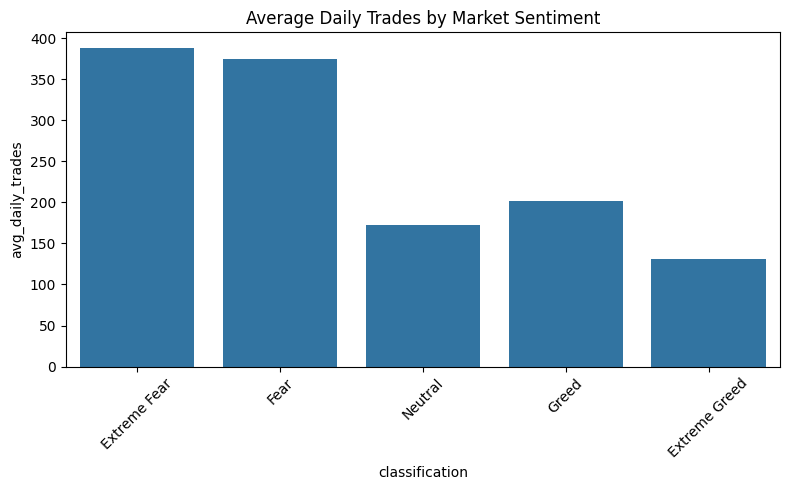

In [69]:
plt.figure(figsize=(8,5))
sns.barplot(data=sentiment_analysis, x='classification', y='avg_daily_trades')
plt.title('Average Daily Trades by Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


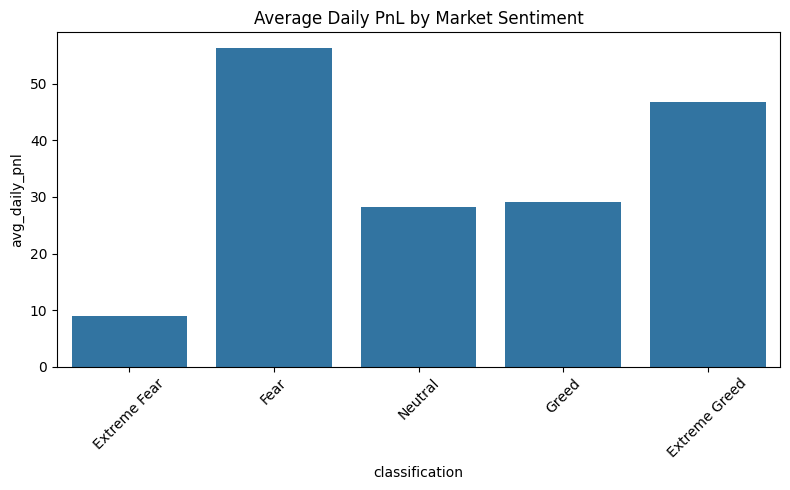

In [70]:
plt.figure(figsize=(8,5))
sns.barplot(data=sentiment_analysis, x='classification', y='avg_daily_pnl')
plt.title('Average Daily PnL by Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


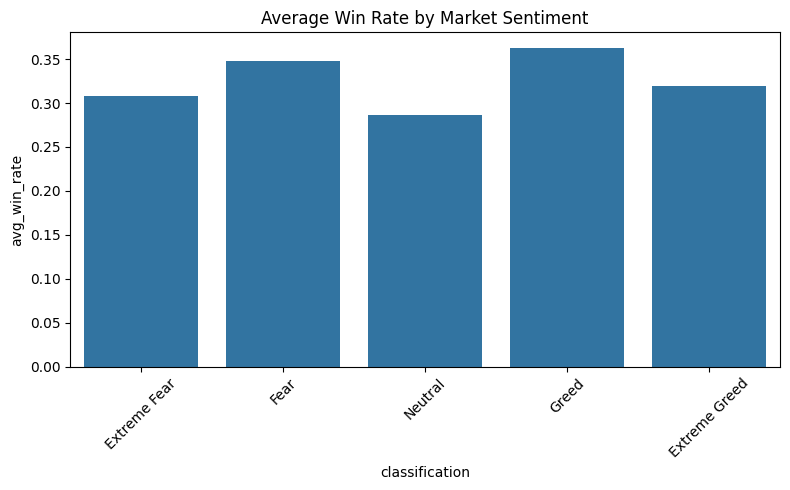

In [71]:
plt.figure(figsize=(8,5))
sns.barplot(data=sentiment_analysis, x='classification', y='avg_win_rate')
plt.title('Average Win Rate by Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Key Insights**
1. Higher trading activity during Fear phases
Trading activity is noticeably higher during Fear and Extreme Fear periods compared to Greed phases. This suggests traders tend to be more active when the market is uncertain or volatile.

2. Profitability appears stronger in Fear conditions
Average daily PnL is highest during Fear periods. One possible explanation is that volatile markets create more short-term trading opportunities.

3. Win rate is slightly higher during Greed
Although trading frequency is lower, the average win rate peaks during Greed phases. This may indicate that trades taken during bullish sentiment are more selective.

4. Extreme Greed shows reduced participation
Trading activity drops significantly during Extreme Greed, which could suggest fewer attractive opportunities or more cautious positioning after strong market moves.

**Actionable Recommendations**

1. **Monitor risk during Fear-driven activity spikes**
Since trading activity increases during Fear periods, platforms could implement risk alerts or position size warnings to help prevent over-trading.

2. **Leverage volatility-aware strategies in fearful markets**
Given the higher observed profitability during Fear phases, traders may benefit from strategies designed to capture short-term volatility.

3. **Encourage disciplined trading during Greed phases**
Because win rates are higher but activity is lower in Greed conditions, traders may benefit from maintaining selective, high-conviction trades rather than increasing frequency.

In [72]:
# Create binary target: profitable day or not
merged_df['profitable_day'] = (merged_df['avg_pnl'] > 0).astype(int)

merged_df[['avg_pnl', 'profitable_day']].head()


,avg_pnl,profitable_day
0,0.000000,0
1,0.000000,0
2,-7.196192,0
3,0.000000,0
4,60.176945,1


In [73]:
# Select features for the model
model_df = merged_df.copy()

# Encode sentiment as numeric
model_df['sentiment_score'] = model_df['value']

features = [
    'total_trades',
    'total_volume_usd',
    'buy_trades',
    'sell_trades',
    'sentiment_score'
]

X = model_df[features]
y = model_df['profitable_day']

print("Feature shape:", X.shape)
print("Target distribution:")
print(y.value_counts())


Feature shape: (158, 5)
Target distribution:
profitable_day
1    109
0     49
Name: count, dtype: int64


In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (110, 5)
Test size: (48, 5)


In [75]:
from sklearn.linear_model import LogisticRegression

# Train model with class balancing
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

print("Model training complete.")



Model training complete.


In [76]:
from sklearn.metrics import accuracy_score, classification_report

# Predictions
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc, 3))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.417

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.67      0.42        15
           1       0.67      0.30      0.42        33

    accuracy                           0.42        48
   macro avg       0.48      0.48      0.42        48
weighted avg       0.55      0.42      0.42        48



**Simple Predictive Model**

As an additional step, a logistic regression model was trained to predict whether a trading day would be profitable using trading activity and sentiment features.

Because the dataset showed class imbalance, balanced class weights were used to ensure the model learned patterns from both profitable and non-profitable days.

The model achieves moderate predictive performance and demonstrates how sentiment and behavioral metrics can be combined for simple outcome prediction.